In [9]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [11]:
IMAGE_SIZE=256
EPOCHE_SIZE=10
BATCH_SIZE=32
AUTOTUNE=tf.data.AUTOTUNE
CHANNELS = 3

In [30]:
# Train dataset
dataset_train = tf.keras.preprocessing.image_dataset_from_directory(
    "train_data/train",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Test dataset
dataset_test = tf.keras.preprocessing.image_dataset_from_directory(
    "test_data/test",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

# Validation dataset
dataset_val = tf.keras.preprocessing.image_dataset_from_directory(
    "val_data/val",
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.


In [31]:
classes = dataset_train.class_names
classes

['NORMAL', 'PNEUMONIA']

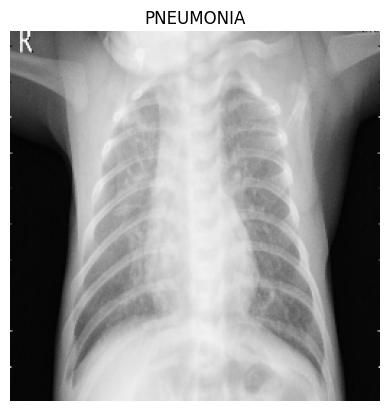

5216


In [32]:
for images,labels in dataset_train.take(1):
  # print(images[0].shape)
  # print(labels.numpy()) #this gives a 2d array but if we dont convert it into numpyt then it gives tensor
  # print(images[0]) #it gives tensor of images with rgb values
  plt.imshow(images[0].numpy().astype("uint8")) # used to show the image and takes 2d array
  plt.axis("off")
  plt.title(classes[labels[0]])
  plt.show()
  print(len(dataset_train)*32)

In [33]:
dataset_train = dataset_train.cache().shuffle(900).prefetch(buffer_size=AUTOTUNE)
dataset_test = dataset_test.cache().shuffle(900).prefetch(buffer_size=AUTOTUNE)
dataset_val = dataset_val.cache().shuffle(900).prefetch(buffer_size=AUTOTUNE)
# val dataset is used while epoche iteration for new records( epoche is train over same data with augmentation)
# cache() this function store the data in cache memory to reduce the time to load data from disk while epoche
# prefecth() this function is used to do parallel processing of data like if gpu train the data then cpu load the next iteration

In [34]:
resize_rescale_layer = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),   # this is used to resize the given image according to the size on which the model trains
    tf.keras.layers.Rescaling(1.0/255) # it is used to convert the value which ranges from 0-255 to 0-1 only
])

In [35]:
data_augmentation_layer = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), # it uses for data augmentation so that if model have a flipped image or then this layer can detect it
    tf.keras.layers.RandomRotation(0.3) # this layer is used for detecting the image with some rotation
])

In [36]:
model = models.Sequential([
    resize_rescale_layer, # this uses the above defined layer of resize and rescale basically preprocessing
    data_augmentation_layer, # similarly this is preprocessing augmenation layer
    layers.Conv2D(32,(3,3), activation='relu', input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)), # this is the first convolution layer that takes first parameter sa 32=> filter_size(nose,ear in kuala example), then kernal_size is 3x3 , input_size that takes (batch size,Image_size,Image_size,channels(rgb here))
    layers.MaxPool2D((2,2)), # this is pooling layer of cnn uses to downsample and reduces complexity here we use maxPooling that means take max from 2x2 grid
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.Flatten(), # this layer flatten the result in 1D to input to dense layer
    layers.Dense(64,activation='relu'), # this is dense layer that mainly gives result on the basis of convo layer result
    layers.Dense(2,activation='softmax') # this is last dense layer for classification
])

model.build(input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)) # dont add too many layer as it shrink the layer too much

c:\Users\sharm\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 57600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │     3,686,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 2)                │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,742,914 (14.28 MB)

 Trainable params: 3,742,914 (14.28 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [39]:
saved_model = model.fit(
    dataset_train,
    verbose=2,
    epochs=EPOCHE_SIZE,
    validation_data=dataset_val
)

Epoch 1/10
163/163 - 300s - 2s/step - accuracy: 0.7979 - loss: 0.4390 - val_accuracy: 0.8125 - val_loss: 0.7417
Epoch 2/10
163/163 - 217s - 1s/step - accuracy: 0.8961 - loss: 0.2555 - val_accuracy: 0.8125 - val_loss: 0.7644
Epoch 3/10
163/163 - 259s - 2s/step - accuracy: 0.9099 - loss: 0.2228 - val_accuracy: 0.7500 - val_loss: 0.5321
Epoch 4/10
163/163 - 233s - 1s/step - accuracy: 0.9158 - loss: 0.2076 - val_accuracy: 0.8750 - val_loss: 0.6635
Epoch 5/10
163/163 - 293s - 2s/step - accuracy: 0.9170 - loss: 0.2013 - val_accuracy: 0.7500 - val_loss: 0.8884
Epoch 6/10
163/163 - 281s - 2s/step - accuracy: 0.9256 - loss: 0.1933 - val_accuracy: 0.8125 - val_loss: 0.6534
Epoch 7/10
163/163 - 284s - 2s/step - accuracy: 0.9333 - loss: 0.1779 - val_accuracy: 0.7500 - val_loss: 0.6237
Epoch 8/10
163/163 - 235s - 1s/step - accuracy: 0.9319 - loss: 0.1775 - val_accuracy: 0.7500 - val_loss: 0.5639
Epoch 9/10
163/163 - 214s - 1s/step - accuracy: 0.9383 - loss: 0.1653 - val_accuracy: 0.8125 - val_loss:

In [40]:
score = model.evaluate(dataset_test)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 240ms/step - accuracy: 0.8397 - loss: 0.4466


In [41]:
acc = saved_model.history['accuracy']
val_acc = saved_model.history['val_accuracy']

loss = saved_model.history['loss']
val_loss = saved_model.history['val_loss']

Text(0.5, 1.0, 'Training and Val accouracy chart according to epochs')

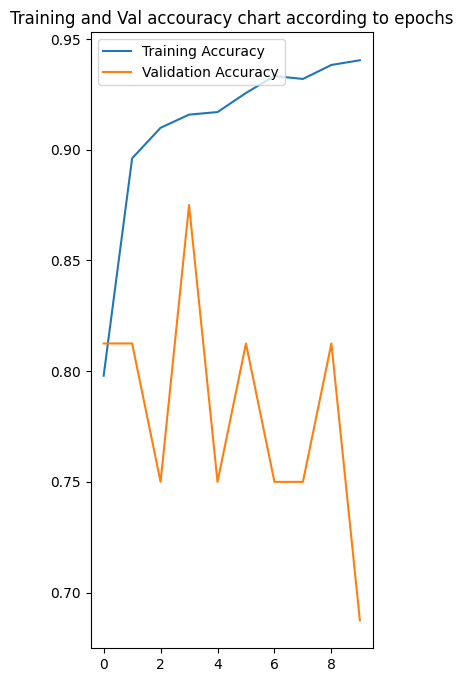

In [42]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHE_SIZE),acc,label="Training Accuracy")
plt.plot(range(EPOCHE_SIZE),val_acc,label="Validation Accuracy")
plt.legend(loc="upper left")
plt.title("Training and Val accouracy chart according to epochs")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
actual label is  PNEUMONIA
predicted label class :  PNEUMONIA


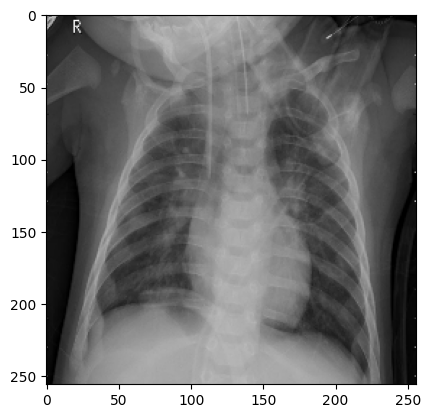

In [58]:
for images_batch, labels_batch in dataset_test.take(1):
  image = images_batch[0].numpy().astype("uint8")
  actual_label = labels_batch[0]
  predicted_labels= model.predict(images_batch)
  print("actual label is ",classes[actual_label])
  print("predicted label class : ",classes[np.argmax(predicted_labels[0])])
  plt.imshow(image)

In [62]:
import os
os.makedirs("models", exist_ok=True)

# Save model
model_v = 1
model.save(f"models/{model_v}.keras")